# Denoising using Dictionary Learning

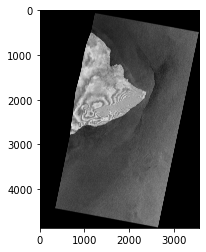

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = mpimg.imread('/Users/meghna_mac2/Documents/cnninsar-master/S1-IFG_RM_M1S3_TN087_20180505T161552-20180423T161459_s1-resorb-a441-v1.1.3-standard/filt_topophase.unw.geo.png')     
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [2]:

height, width = gray.shape

# Distort the right half of the image
print("Distorting image...")
distorted = gray.copy()
distorted[:, width // 2 :] += 0.075 * np.random.randn(height, width // 2)



Distorting image...


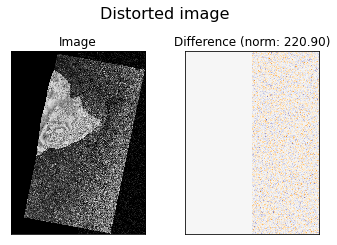

In [3]:
def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, gray, "Distorted image")



In [4]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d


# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, : width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))



Extracting reference patches...
8632666 patches extracted in 18.32s.


Learning the dictionary...
10 iterations in 247.55.


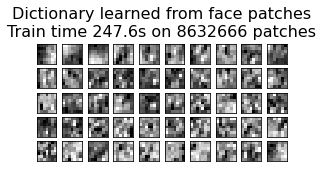

In [9]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=200,
    alpha=1.0, 
    n_iter=10
)
V = dico.fit(data).components_
dt = time() - t0
# print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")
print(f"{dico.n_iter_} iterations in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)



Extracting noisy patches... 
done in 2.93s.
Orthogonal Matching Pursuit
1 atom...
done in 245.02s.
Orthogonal Matching Pursuit
2 atoms...
done in 461.62s.
Least-angle regression
4 atoms...
done in 3789.06s.
Thresholding
 alpha=0.1...
done in 85.48s.


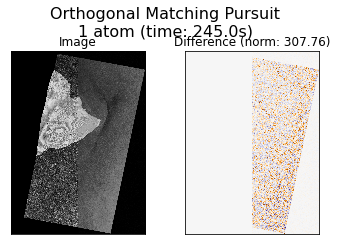

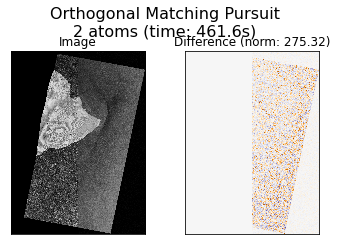

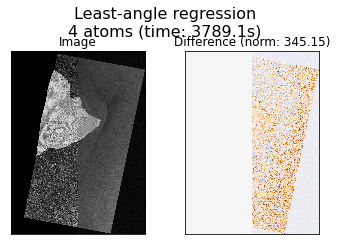

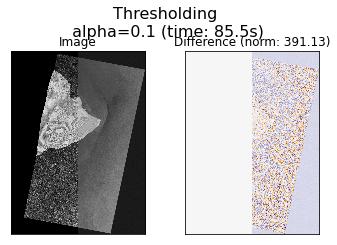

In [12]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = gray.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], gray, title + " (time: %.1fs)" % dt)

plt.show()

